# Model Analysis - Surface Accessability

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42

from matplotlib.ticker import ScalarFormatter
%matplotlib inline

## Constants

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/model_analysis_surface_acc'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
from importlib import reload
if LOCAL_DIR not in sys.path: 
    sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#load sequences
sequences = FHS.get_sequences_df(only_tested=False)

#load structural annotations
dssp_df = FHS.get_dssp().rename(columns={'position': 'pdb_num'})
dssp_df = FHS.add_model_num_from_pdb_num(
    dssp_df, 'pdb_num', 'model_num'
)
dssp_df = dssp_df.dropna(subset='model_num')
dssp_df = dssp_df[['pdb_num', 'model_num', 'aa', 'relative_acc']]

In [5]:
def get_dssp_df():
    mutated_model_positions = list(
        sequences[
            sequences.is_design==1
        ].model_mutations.explode().apply(
            lambda mut: int(mut[1:-1])
        ).unique()
    )
    return dssp_df.assign(
        mutated = lambda df: df.model_num.apply(
            lambda model_num: model_num in mutated_model_positions
        )
    ).sort_values(by='model_num').reset_index(drop=True)

## Plotting

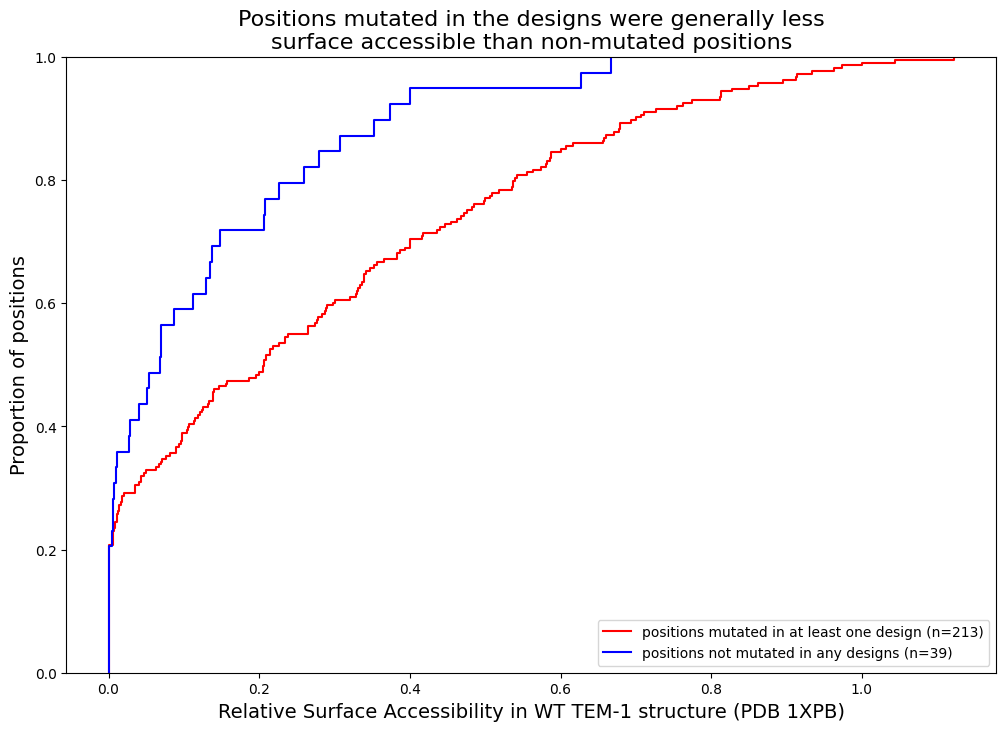

In [6]:
def plot_surface_accessibility_ecdf():
    plotting_df = get_dssp_df()
    mutated_dssp_df = plotting_df[plotting_df.mutated==True]
    nonmutated_dssp_df = plotting_df[plotting_df.mutated==False]
    
    #plot
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    sns.ecdfplot(
        mutated_dssp_df, x='relative_acc', color='red', ax=ax, 
        label='positions mutated in at least one design (n={0})'.format(len(
            mutated_dssp_df
        ))
    )
    sns.ecdfplot(
        nonmutated_dssp_df, x='relative_acc', color='blue', ax=ax,
        label='positions not mutated in any designs (n={0})'.format(len(
            nonmutated_dssp_df
        ))
    )

    #decorate
    ax.set_title(
        'Positions mutated in the designs were generally less\n'+
        'surface accessible than non-mutated positions',
        fontsize=16
    )
    ax.set_ylabel('Proportion of positions', fontsize=14)
    ax.set_xlabel(
        'Relative Surface Accessibility in WT TEM-1 structure (PDB 1XPB)', 
        fontsize=14
    )
    ax.legend(loc='lower right')
    fig.savefig(OUTPUT_DIR+'/model_analysis_surface_acc.pdf')

plot_surface_accessibility_ecdf()

In [7]:
def get_cdf_source_data():
    tmp_df = get_dssp_df()[[
        'model_num', 'aa', 'mutated', 'relative_acc'
    ]].rename(columns={
        'model_num': 'Position (model numbering)',
        'aa': 'Amino Acid',
        'mutated': 'Mutated in at Least One Design',
        'relative_acc': 'Surface Accessibility',
    })
    #sns.ecdfplot(
    #    data=tmp_df, 
    #    x='Surface Accessibility', 
    #    hue='Mutated in at Least One Design',
    #)
    return tmp_df
    
get_cdf_source_data().to_csv(
    OUTPUT_DIR+'/model_analysis_surface_acc.tab', 
    sep ='\t', 
    index=False
)

In [8]:
def get_core_residue_mutation_count(sample_order, max_core = 0):
    toreturn = {
        'manuscript_name': [],
        'core_count': [],
        #'mutated_positions': [],
    }
    for manuscript_name in sample_order:
    #for idx, row in sequences.iterrows():
        row = sequences[sequences.manuscript_name == manuscript_name].iloc[0]
        
        mutated_positions = [int(mut[1:-1]) for mut in row.model_mutations]
        core_count = 0
        for pos in mutated_positions:
            if dssp_df[dssp_df.model_num == pos].iloc[0].relative_acc <= max_core:
                core_count += 1
        toreturn['manuscript_name'].append(row.manuscript_name)
        toreturn['core_count'].append(core_count)
        #toreturn['mutated_positions'].append(mutated_positions)
    return pd.DataFrame(toreturn)

sample_order = FHS.get_sample_order(sequences.manuscript_name)
get_core_residue_mutation_count(sample_order, max_core=.2)

,manuscript_name,core_count
0,WT TEM-1,0
1,neg. ctrl,1
2,rw-consensus,51
3,98.a,3
4,98.b,3
5,95.a,5
6,95.b,4
7,90.a,8
8,90.b,6
9,80.a,15


<Axes: xlabel='relative_acc', ylabel='Count'>

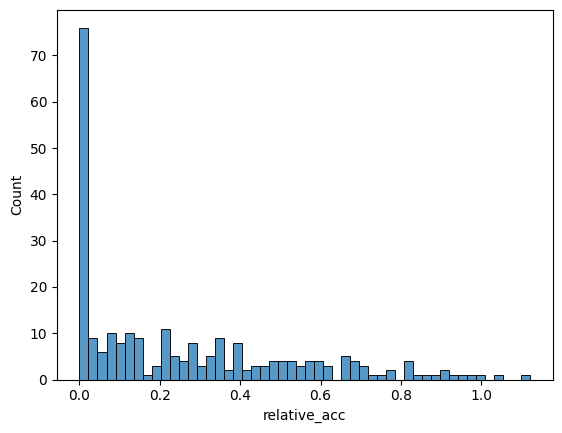

In [9]:
sns.histplot(dssp_df, x='relative_acc', bins=50)